In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from env import get_url

## Plan for Data Preparation:

#### 1. Acquire and Summarize the data
- How many records do we have?
- What data types do we have?
- Are there columns that should become multiple columns?
    - Is a column a string w/ delimeters?
    - A column containing JSON or lists *might* need expansion
- Are there many columns that should become two columns (.melt)
- Do we need to do any joins w/ other tables?
- What exactly is an "observation"? 
- What does each row represent?

#### 2. Handle nulls
- When to remove?
    - The row (individual observation)
    - The column (the entire feature)
- When to replace nulls?
- What to replace nulls with?
 
#### 3. Handle Anomalies/Outliers
- Our first anomaly filter is the IQR Rule
- We'll much deeper into outliers/anomalies in a later module


In [2]:
def get_titanic_data():
    return pd.read_sql('SELECT * FROM passengers', get_url('titanic_db'), index_col="passenger_id")

In [3]:
titanic = get_titanic_data()
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
passenger_id,,,,,,,,,,,,
0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [4]:
titanic.describe()

,survived,pclass,age,sibsp,parch,fare,alone
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.602694
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.489615
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   deck         203 non-null    object 
 10  embark_town  889 non-null    object 
 11  alone        891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [7]:
# Do we have any nulls?
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
deck           688
embark_town      2
alone            0
dtype: int64

In [8]:
titanic.shape

(891, 12)

In [9]:
# Percentage of deck values that are null
titanic.deck.isnull().sum() / len(titanic)

0.7721661054994389

In [10]:
titanic.age.isnull().sum() / len(titanic)

0.19865319865319866

In [12]:
titanic.deck.value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: deck, dtype: int64

In [14]:
titanic[titanic.pclass == 1].deck.value_counts()

C    59
B    47
D    29
E    25
A    15
Name: deck, dtype: int64

In [17]:
# percentage of 1st class data
titanic[titanic.pclass == 1].deck.isna().sum() / len(titanic[titanic.pclass == 1])

0.18981481481481483

In [19]:
titanic[titanic.pclass == 2].deck.value_counts()
titanic[titanic.pclass == 2].deck.isna().sum() / len(titanic[titanic.pclass == 2])

0.9130434782608695

In [16]:
titanic[titanic.pclass == 3].deck.value_counts()

F    5
G    4
E    3
Name: deck, dtype: int64

In [20]:
titanic[titanic.pclass == 3].deck.isna().sum() / len(titanic[titanic.pclass == 3])

0.9755600814663951

## Thoughts so far?
- drop the deck column entirely...
- For the deck data we have, it seems dependent on PClass. So let's use PClass since deck is 77% nulls and seems dependent on PClass already.
- For age, let's impute the age
    - "Use median when you could use mean because it tells you more. And if you could use median, just use median"
- For embark_town, let's impute w/ the most frequent
    - for only 2 values, you could drop those 2 rows or add in the most frequent discrete value

## Take Time to Document:
- Document what you've discovered
- any further questions you have
- what you would do with more time
- What you're dropping and why

## Approach:
- Rows are individual observations 
- Columns are features

In [24]:
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns=cols_to_remove)
    return df

In [25]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .75):
    # column threshold for whether we keep or remove the column
    threshold = int(round(prop_required_column*len(df.index),0))
    # axis=1 argument means "column"
    df.dropna(axis=1, thresh=threshold, inplace=True)
    
    threshold = int(round(prop_required_row*len(df.columns),0))
    # axis=0 argument means "rows"
    # drop the row if over the threshold
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [23]:
def data_prep(df, cols_to_remove=[], prop_required_column=.5, prop_required_row=.75):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [26]:
titanic = data_prep(titanic)

In [27]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone
passenger_id,,,,,,,,,,,
0,0,3,male,22.0,1,0,7.2500,S,Third,Southampton,0
1,1,1,female,38.0,1,0,71.2833,C,First,Cherbourg,0
2,1,3,female,26.0,0,0,7.9250,S,Third,Southampton,1
3,1,1,female,35.0,1,0,53.1000,S,First,Southampton,0
4,0,3,male,35.0,0,0,8.0500,S,Third,Southampton,1


In [28]:
titanic.shape

(891, 11)

## Let's Handle Some Outliers!

In [32]:
sql = """SELECT * FROM customers"""
url = get_url("mall_customers")
df = pd.read_sql(sql, url)

In [34]:
df = df.set_index("customer_id")
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


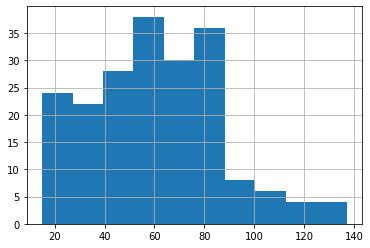

In [38]:
df.annual_income.hist()

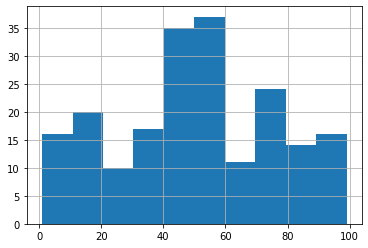

In [39]:
df.spending_score.hist()

# From Medians to Quartiles 
- the median is a breakpoint in the data that separates the bottom half from the upper half
- w/ the median, one split point is creating two halves
- the halfway point between the lowest value and the median value is Q1
- from Q1 to the median is our 2nd chunk of 25% of observations, median == Q2
- the halfway point between the median and the highest value is Q3 

- IQR = Q3 - Q1

In [48]:
numbers = np.arange(1, 101)
numbers = pd.Series(numbers)
numbers

0       1
1       2
2       3
3       4
4       5
     ... 
95     96
96     97
97     98
98     99
99    100
Length: 100, dtype: int64

In [49]:
numbers.median()

50.5

In [50]:
q1 = numbers.quantile(.25)
q1

25.75

In [51]:
q3 = numbers.quantile(.75)
q3

75.25

In [52]:
# interquartile range is q3 - q1
iqr = q3 - q1
iqr

49.5

- All the numbers in the range from minimum to Q1 are your first 25% of observations => first quarter
- All the numbers between Q1 and the median is your 2nd quarter
- All the numbers between Q2 and Q3 are your 3rd quarter
- All the numbers between Q3 and max value in the observation is your 4th quarter 

In [53]:
# IQR Rule - we'll use the IQR times a constant called "k"
# k is usually 1.5 (first definition of IQR range rule is 1.5)
# k value to catch more values ensure outliers are much farther away is 3

upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

In [54]:
upper_bound

149.5

In [55]:
lower_bound

-48.5

- Use 1.5 for "mild outliers" => you capture more outliers
- Use 3 for "extreme outliers" => you capture less outliers that are much farther away

In [56]:
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
    #                 for col in df.select_dtypes('number')}
    # return df.assign(**outlier_cols)

    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

df = add_upper_outlier_columns(df, k=1.5)
df

,gender,age,annual_income,spending_score,age_outliers,annual_income_outliers,spending_score_outliers
customer_id,,,,,,,
1,Male,19,15,39,0,0.00,0
2,Male,21,15,81,0,0.00,0
3,Female,20,16,6,0,0.00,0
4,Female,23,16,77,0,0.00,0
5,Female,31,17,40,0,0.00,0
...,...,...,...,...,...,...,...
196,Female,35,120,79,0,0.00,0
197,Female,45,126,28,0,0.00,0
198,Male,32,126,74,0,0.00,0


In [ ]:
# it's possible to make two different variables
# mild_outliers  using 1.5
# extreme_outliers using 3